In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection

import time
#from matplotlib import pyplot as plt
from matplotlib import pylab as plt
from IPython import display

from Funciones import evaluar, evaluarDerivada

In [3]:
df = pd.read_csv(DATOS_DIR+'iris.csv')
nomClases = pd.unique(df['class'])

df

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [4]:
# Tomamos todas las columnas menos la última
X = np.array(df.iloc[:, 0:-1])
T= np.array(df.iloc[:,-1])

T[:5]

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa'], dtype=object)

In [5]:
le = preprocessing.LabelEncoder()
T = le.fit_transform(T)
T[:5]

array([0, 0, 0, 0, 0])

In [6]:
entradas = X.shape[1]
ocultas = 2

#-- la red tendrá una salida para cada tipo de flor
salidas = len(np.unique(T))
print("entradas = %d ; salidas = %d" % (entradas, salidas))

entradas = 4 ; salidas = 3


In [7]:
#--- CONJUNTOS DE ENTRENAMIENTO Y TESTEO ---
X_train, X_test, T_train, T_test = model_selection.train_test_split( \
        X,T, test_size=0.30)#, random_state=42)

normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre 0 y 1
    min_max_scaler = preprocessing.StandardScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    
T_trainB = np.zeros((len(T_train), salidas))
for o in range(len(T_train)):
    T_trainB[o, T_train[o]]=1   
    
print("T_train :")
print(T_train[:5])

print("\nT_trainB : ")
print(T_trainB[:5, :]  )  

T_train :
[2 1 0 2 1]

T_trainB : 
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [8]:
W1 = np.random.uniform(-0.5,0.5,[ocultas, entradas])
b1 = np.random.uniform(-0.5,0.5, [ocultas,1])
W2 = np.random.uniform(-0.5,0.5,[salidas, ocultas])
b2 = np.random.uniform(-0.5,0.5, [salidas,1])

In [9]:
FunH = 'sigmoid'  #'relu'
FunO = 'softmax'   #'tanh'

if (FunO=='tanh'):
    T_trainB = 2*T_trainB -1
#    T_testB  = 2*T_testB - 1

In [10]:
nFilas = X_train.shape[0]

alfa = 0.05
CotaError = 1.0e-5
MAX_EPOCAS = 1000
epoca = 0
errorAnt = 0
AVGError = 1
errores = []
ph=0
while ( abs(AVGError-errorAnt) > CotaError ) and ( epoca < MAX_EPOCAS ):
    errorAnt = AVGError
    AVGError = 0
    for e in range(nFilas):  #para cada ejemplo
        
        xi = X_train[e:e+1, :]     # ejemplo a ingresar a la red
        ti = T_trainB[e:e+1, :]     # salida esperada para el ejemplo seleccionado
        
        # propagar el ejemplo hacia adelante
        netasH = W1 @ xi.T + b1
        salidasH = evaluar(FunH, netasH)
        netasO = W2 @ salidasH + b2
        salidasO = evaluar(FunO, netasO)

        # calcular los errores en ambas capas        
        ErrorSalida = ti.T-salidasO
        
        deltaO = ErrorSalida      # * evaluarDerivada(FunO,salidasO)
        deltaH = evaluarDerivada(FunH,salidasH)*(W2.T @ deltaO)

        # corregir todos los pesos      
        W1 = W1 + alfa * deltaH @ xi 
        b1 = b1 + alfa * deltaH 
        W2 = W2 + alfa * deltaO @ salidasH.T 
        b2 = b2 + alfa * deltaO 

        AVGError = AVGError + np.mean(ErrorSalida**2)
    
    AVGError = AVGError / nFilas
    errores.append(AVGError)
    
    epoca = epoca + 1

In [11]:
print(W1)
print(b1)
print(W2)
print(b2)


[[-0.65415962  1.74520033 -2.74883114 -2.03784418]
 [ 0.44413794  0.73700201 -3.50916348 -4.16156937]]
[[-1.55188868]
 [ 4.46871719]]
[[ 6.04879049  3.46561998]
 [-3.80871598  4.53822462]
 [-1.71487746 -7.25266567]]
[[-4.07689194]
 [-0.44454398]
 [ 4.82828956]]


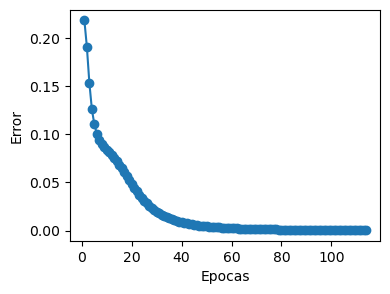

In [12]:
plt.figure(figsize=(4,3))
plt.plot(range(1, len(errores) + 1), errores, marker='o')
plt.xlabel('Epocas')
plt.ylabel('Error')
plt.show()

In [13]:
# Respuesta de la red para los datos de ENTRENAMIENTO ---
NetasH = W1 @ X_train.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)
SalidasO[:, :2]

array([[1.42763872e-04, 1.57998062e-02],
       [5.42619631e-03, 9.81274513e-01],
       [9.94431040e-01, 2.92568053e-03]])

In [14]:
Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_train : %.3f" % metrics.accuracy_score(T_train,Y_pred))

% aciertos X_train : 1.000


In [15]:
report = metrics.classification_report(T_train,Y_pred)
print("Confusion matrix Training:\n%s" % report) 

Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        39

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



In [16]:
MM = metrics.confusion_matrix(T_train,Y_pred)
print("Confusion matrix:\n%s" % MM)

Confusion matrix:
[[41  0  0]
 [ 0 25  0]
 [ 0  0 39]]


In [17]:
# -- TESTING ---
NetasH = W1 @ X_test.T + b1
SalidasH = evaluar(FunH, NetasH)
NetasO = W2 @ SalidasH + b2
SalidasO = evaluar(FunO, NetasO)

Y_pred = np.argmax(SalidasO,axis=0)
print("%% aciertos X_test : %.3f\n" % metrics.accuracy_score(T_test,Y_pred))

report = metrics.classification_report(le.inverse_transform(T_test),le.inverse_transform(Y_pred))
print("Confusion matrix Test:\n%s" % report) 

MM = metrics.confusion_matrix(T_test, Y_pred)
print("Confusion matrix:\n%s" % MM)

% aciertos X_test : 0.889

Confusion matrix Test:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         9
Iris-versicolor       1.00      0.80      0.89        25
 Iris-virginica       0.69      1.00      0.81        11

       accuracy                           0.89        45
      macro avg       0.90      0.93      0.90        45
   weighted avg       0.92      0.89      0.89        45

Confusion matrix:
[[ 9  0  0]
 [ 0 20  5]
 [ 0  0 11]]
